# Credit Card Fraud Detection
## Anonymized Credit Card transactions labeled as Fraudulent or Genuine

![](https://www.greedyrates.ca/wp-content/uploads/2013/04/Chief-Justice-Roberts-Hit-By-Credit-Card-Fraud-394x222-c-default.jpg)

In [1]:
import pandas as pd
import numpy as np
#import pickle
#import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1)
sns.despine(left=True);
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 10,4
labels = ["Normal", "Fraud"]

<Figure size 432x288 with 0 Axes>

## Credit Card Fraud Detection
Anonymized credit card transactions labeled as fraudulent or genuine

[Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [3]:
df = pd.read_csv("creditcard.csv")
print('Dataset shape',df.shape)
print('\nColumns',df.columns.values)
print('\nNull Values:\n',df.isnull().values.any())
df.head(3)

Dataset shape (284807, 31)

Columns ['Time' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12'
 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24'
 'V25' 'V26' 'V27' 'V28' 'Amount' 'Class']

Null Values:
 False


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


**Features Description**

1. Features V1, V2, ... V28 are the principal components obtained with PCA
2. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
3. Amount is the transaction Amount, 

### Percentage of each Class represents in the skewed distribution

In [4]:
fraud = df[df.Class == 1]
geniune = df[df.Class == 0]
print('Fraud shape: ' + str(fraud.shape))
print('Valid shape: ' + str(geniune.shape))

print('\nNo Fraud: ', round(len(fraud)/len(df) * 100,2), '% of the dataset.')
print('Fraud: ', round(len(geniune)/len(df) * 100,2), '% of the dataset.')

Fraud shape: (492, 31)
Valid shape: (284315, 31)

No Fraud:  0.17 % of the dataset.
Fraud:  99.83 % of the dataset.


**Description**
-  The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
-  This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 

<font color='blue'>**It is clear that the data is highly unbalanced**</font> 

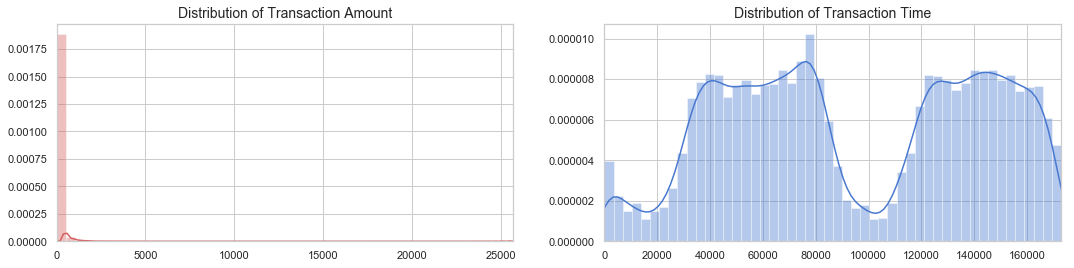

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### Scaling and Distributing
In this phase of our kernel, we will first scale the columns comprise of Time and Amount . Time and amount should be scaled as the other columns.

## Visualize Fraud and NonFraud Transactions
We will visualize the nature of fraud and non-fraud transactions using T-SNE.

T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dataset decomposition technique which reduced the dimentions of data and produces only top n components with maximum information.

It is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.

In [6]:
non_fraud = df[df['Class'] == 0].sample(1000)
fraud = df[df['Class'] == 1]

df1 = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df1.drop(['Class'], axis = 1).values
Y = df1["Class"].values

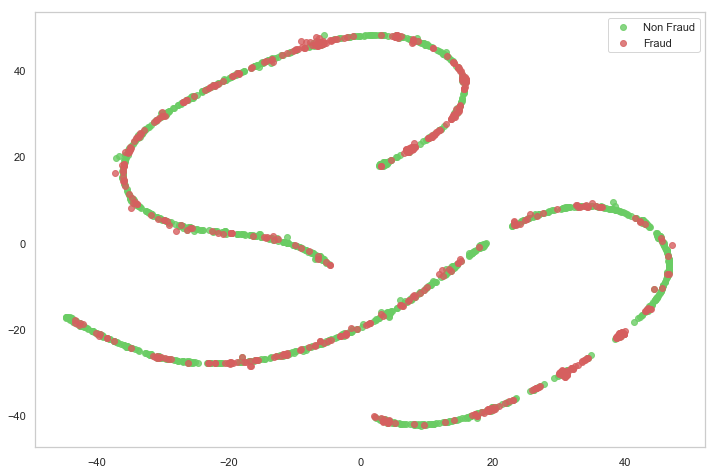

In [7]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.grid(False)
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [81]:
from sklearn.preprocessing import StandardScaler
# Time is only an indicator instead of a useful feature.
data = df.drop(['Time'], axis=1)
#data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

### Density distribution of each feature w.r.t. the Class.

In [8]:
data1 = df.drop(['Time'], axis=1)
data1=data1.iloc[:10000,:]

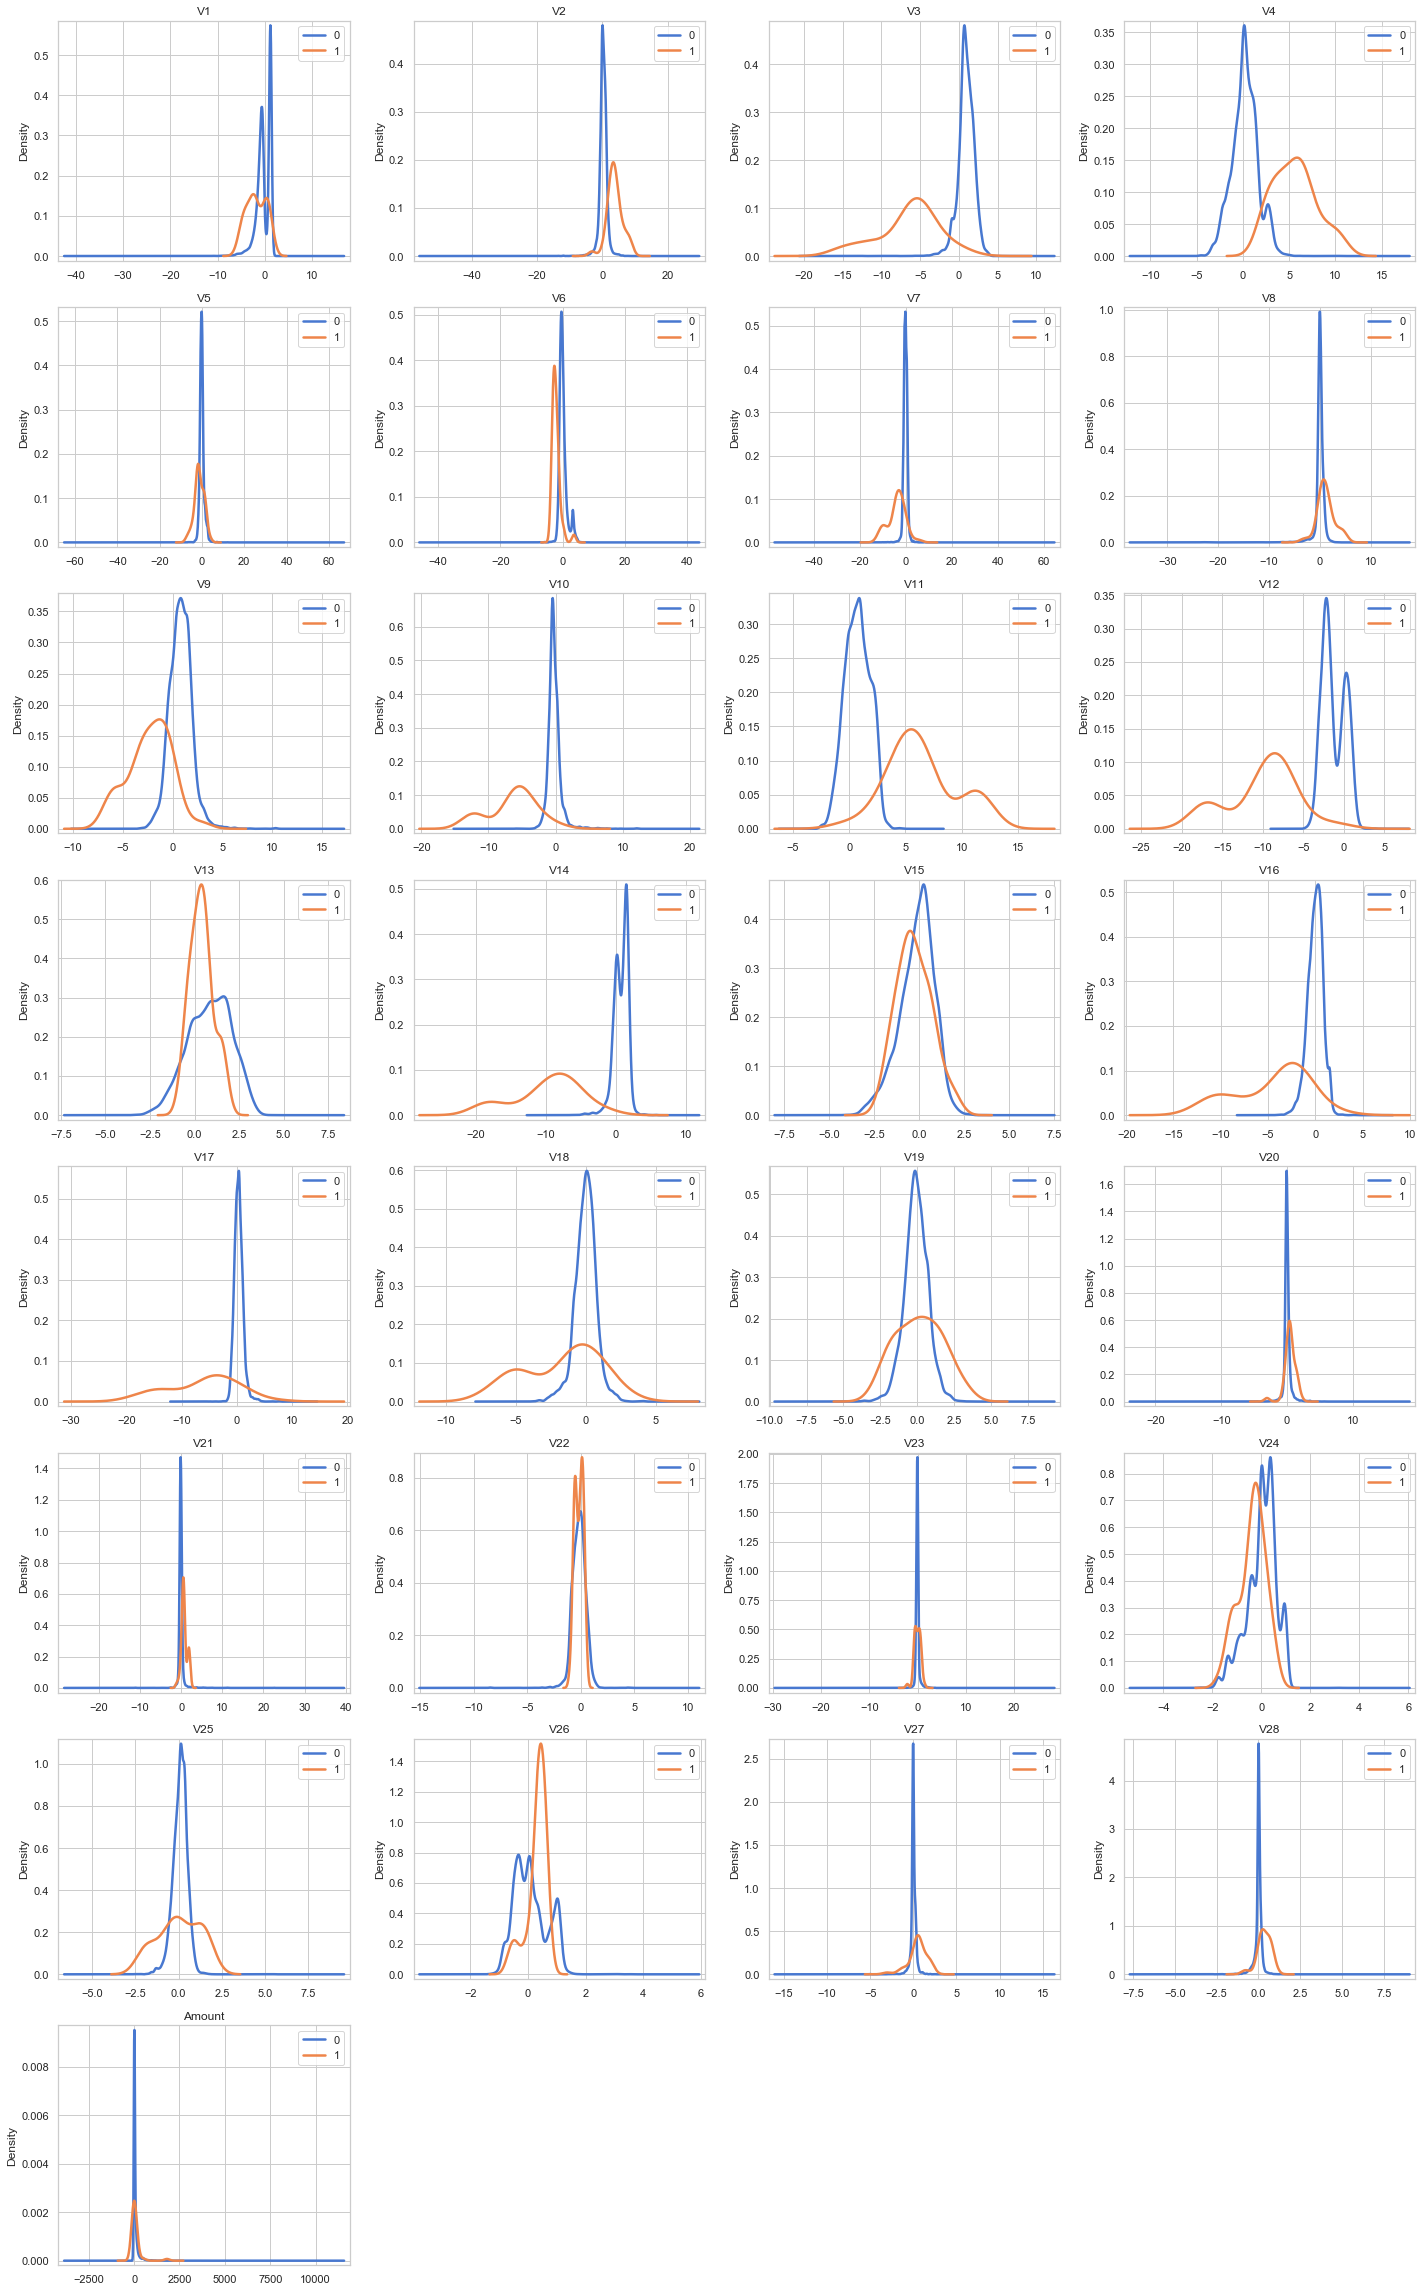

In [9]:
# Scatter subplots
plt.figure(figsize=(20,32))
for plot, feat in enumerate(data1.columns[:-1]):
    plt.subplot(8, 4, (plot+1))
    title = str(feat)
    
    # Normalise to visualise the differences in distributions
    temp_df = pd.concat([data1[feat], data1['Class']], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='kde', alpha=1, legend='best', lw=2.5)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()

## SMOTE : Synthetic Minority Oversampling Technique

Methods to over-sample minority classes. We will populate the minority class with synthetic data through SMOTE. 

Note that over-sampling is only applied to training data. 
Testing of learned models must be conducted on original data.

**Working:**

This is a statistical technique for increasing the number of cases in your dataset in a balanced way. The module works by generating new instances from existing minority cases that you supply as input. This implementation of SMOTE does not change the number of majority cases.

This algorithm creates new instances of the minority class by creating convex combinations of neighboring instances.

In [10]:
from sklearn.preprocessing import StandardScaler
# Time is only an indicator instead of a useful feature.
data = df.drop(['Time'], axis=1)
data.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [11]:
train_data,test_data = train_test_split(data, test_size=0.33, random_state=42)
print(train_data.shape, test_data.shape)

(190820, 30) (93987, 30)


In [12]:
sc = StandardScaler()
train_data['Amount'] = sc.fit_transform(train_data['Amount'].values.reshape(-1,1))

features = data.columns
features = [str(s) for s in features]
label = features[-1]
features = features[:-1]

#### Using SMOTE on Training Data

In [13]:
X=train_data.iloc[:,:-1]
y=train_data.Class
sm = SMOTE(ratio = 'auto', kind = 'regular', random_state = 1)
sample_X, sample_y = sm.fit_sample(X, y)
sample = pd.concat([pd.DataFrame(sample_X), pd.DataFrame(sample_y)], axis = 1)
sample.columns = features + [label]

- sampling_strategy:'auto', resample all classes but the majority class
- regular: The type of SMOTE algorithm to use

In [14]:
sample.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.146174,-0.083967,0.602963,0.725410,-0.396283,0.186275,-0.318544,0.185287,0.362387,-0.085385,...,-0.012052,0.219314,-0.068172,0.077802,0.482796,0.451360,-0.002776,-0.003524,-0.331517,0
1,-0.918050,0.578744,1.168159,-0.862173,0.969264,0.483973,0.953430,0.188512,-0.866718,-0.734780,...,0.102956,0.073220,-0.324398,-1.129387,0.622502,0.395548,-0.042526,0.032731,-0.062122,0


In [15]:
print ('No. of fraudulent transactions: {0:g}\nNo. of genuine transactions: {1:g}'.format( \
        np.sum(sample['Class'] == 0), np.sum(sample['Class'] == 1)))

No. of fraudulent transactions: 190477
No. of genuine transactions: 190477


In [16]:
X_train=sample.iloc[:,:-1]
y_train=sample.Class

X_test = test_data[features] #Without applying SMOTE
X_test['Amount'] = sc.transform(X_test['Amount'].values.reshape(-1, 1))
y_test = test_data[label]

In [17]:
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((380954, 29), (380954,), (93987, 29), (93987,))

## 1. Logistic Regression

Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem.

In [18]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred.round())

print('Precision Score: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Recall Score: {:.3f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.3f}'.format(f1_score(y_test, y_pred)))
print('Accuracy Score: {:.4f}'.format(accuracy_score(y_test, y_pred)))
cnf_matrix

Precision Score: 0.879
Recall Score: 0.631
F1 Score: 0.734
Accuracy Score: 0.9993


array([[93825,    13],
       [   55,    94]], dtype=int64)

## 2. Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fittin

In [75]:
clf = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

ValueError: Number of labels=380954 does not match number of samples=227451

In [21]:
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred.round())

print('Precision Score: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Recall Score: {:.3f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.3f}'.format(f1_score(y_test, y_pred)))
print('Accuracy Score: {:.3f}'.format(accuracy_score(y_test, y_pred)))
cnf_matrix

Precision Score: 0.846
Recall Score: 0.846
F1 Score: 0.846
Accuracy Score: 1.000


array([[93815,    23],
       [   23,   126]], dtype=int64)

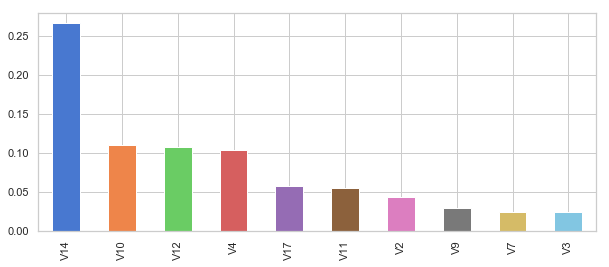

In [22]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='bar');

In [74]:
feat_imp = pd.DataFrame({'importance':clf.feature_importances_})   
feat_imp.insert(loc=0, column='feature', value=X_train.columns)
#feat_imp['feature'] = sample_X.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.reset_index(drop=True)
feat_imp = feat_imp.iloc[:24]
feat_imp

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## 3. XGBoost
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning.

In [24]:
clf1 = XGBClassifier(n_estimators=50, max_depth=10,random_state=0, n_jobs=-1)
clf1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [25]:
y_pred = clf1.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred.round())

print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred)))
cnf_matrix

Precision Score: 0.54
Recall Score: 0.86
F1 Score: 0.66
Accuracy Score: 1.00


array([[93728,   110],
       [   21,   128]], dtype=int64)

## Disadvantage of using SMOTE

- SMOTE can lead to overfitting issues due to multiple realted instances
- While generating synthetic examples, SMOTE does not take into consideration neighboring examples can be from other classes. This can increase the overlapping of classes and can introduce additional noise.

In [26]:
# Features selected using Random Forest
names=feat_imp.feature.values
X=data.loc[:,names]
y=data.Class
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
print(X.shape, y.shape)

(284807, 20) (284807,)


## AutoEncoders
Autoencoders are a special type of neural network architectures in which the output is same as the input. Autoencoders are trained in an unsupervised manner in order to learn the exteremely low level repersentations of the input data. 

These low level features are then deformed back to project the actual data. An autoencoder is a regression task where the network is asked to predict its input (in other words, model the identity function).

These networks has a tight bottleneck of a few neurons in the middle, forcing them to create effective representations that compress the input into a low-dimensional code that can be used by the decoder to reproduce the original input.

**Autoencoders are:**

1. Feed Forward Neural Network models for unsupervised tasks (No Labels).

2. Models that model the identity function f(x) ≈ x .

![](https://cdn-images-1.medium.com/max/400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

## Reconstruction error

The parameters of our Autoencoder model is optimized in such way that the **reconstruction error** is minimized.
In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$

The reconstruction error (RE)is the mean squared distance between input and output.


In the context of anomaly detection and condition monitoring, the basic idea is to use the autoencoder network to “compress” data to a lower-dimensional representation, which captures the correlations and interactions between the various variables. (Essentially the same principle as the PCA model, but here we also allow for non-linear interactions between the variables).

#### We will train our model on the Normal Transactions only

In [28]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
# Use only normal examples
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train=X_train.loc[:,names]

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test=X_test.loc[:,names]
X_train = X_train.values
X_test = X_test.values
X_train.shape, X_test.shape

((227451, 20), (56962, 20))

## AutoEncoder Architecture

The input and out layers have 20 neurons each for the 20 features respectively. 

Our Autoencoder uses 4 fully connected layers with 16, 8, 8 and 16 neurons 

The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training

In [29]:
input_dim = X_train.shape[1]
encoding_dim = 16

# Input layer
input_layer = Input(shape=(input_dim, ))

# Encoding part
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(int(8), activation="relu")(encoder)

# Decoding part
decoder = Dense(int(8), activation='tanh')(encoder)

decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

We now train the model for 50 epochs with a batch size of 32 samples and save the best performing model to a file.

The ModelCheckpoint provided by Keras is used

In [31]:
nb_epoch = 50
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Instructions for updating:
Use the retry module or similar alternatives.
Train on 227451 samples, validate on 56962 samples
Epoch 1/50
227451/227451 [==============================] - 7s 33us/step - loss: 3418.6692 - acc: 0.8577 - val_loss: 2634.0440 - val_acc: 0.8728
Epoch 2/50
227451/227451 [==============================] - 7s 31us/step - loss: 3105.2654 - acc: 0.8803 - val_loss: 2373.9642 - val_acc: 0.8916
Epoch 3/50
227451/227451 [==============================] - 6s 29us/step - loss: 2873.2364 - acc: 0.8936 - val_loss: 2170.9319 - val_acc: 0.8938
Epoch 4/50
227451/227451 [==============================] - 7s 33us/step - loss: 2688.9672 - acc: 0.8996 - val_loss: 2007.7798 - val_acc: 0.9065
Epoch 5/50
227451/227451 [==============================] - 8s 34us/step - loss: 2537.6904 - acc: 0.9004 - val_loss: 1871.1606 - val_acc: 0.9010
Epoch 6/50
227451/227451 [==============================] - 7s 29us/step - loss: 2408.1985 - acc: 0.8991 - val_loss: 1754.8874 - val_acc: 0.9016
Epoch 

**Callbacks**

A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

**Checkpoint Best Neural Network Model Only**

A simpler check-point strategy is to save the model weights to the same file, if and only if the validation accuracy improves.

In [32]:
from importlib import reload
import keras
reload(keras.models)

<module 'keras.models' from 'C:\\Users\\Ali\\Anaconda3\\lib\\site-packages\\keras\\models.py'>

In [33]:
autoencoder = load_model('model.h5')

**Training and Test Loss**

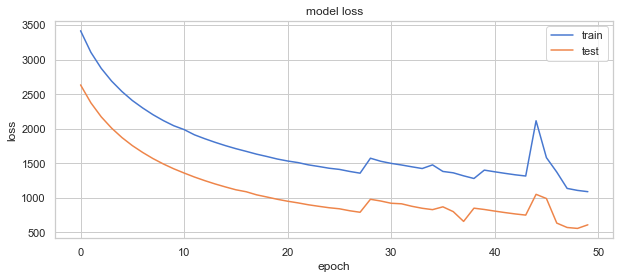

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

* As seen in above figure, the reconstruction error on our training and test data has converged.

**Error Distribution**

In [35]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,5.696200e+04,56962.000000
mean,5.551876e+02,0.001720
std,2.039450e+04,0.041443
min,1.710832e-01,0.000000
25%,9.198745e-01,0.000000
50%,1.785269e+00,0.000000
75%,3.684515e+00,0.000000
max,3.876401e+06,1.000000


**Reconstruction error without Fraud**

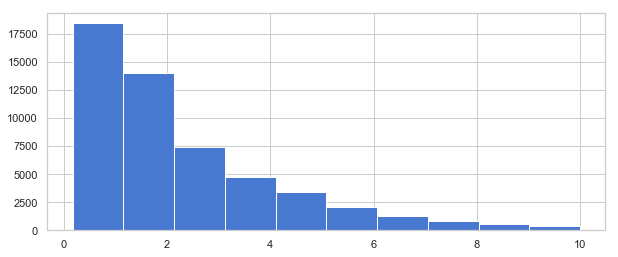

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

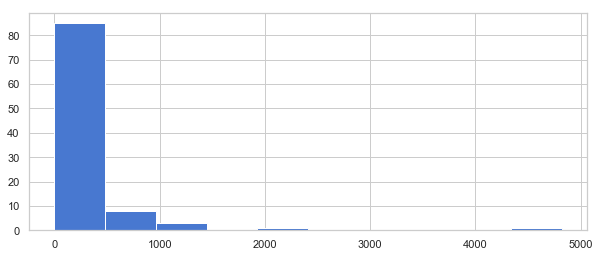

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [38]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

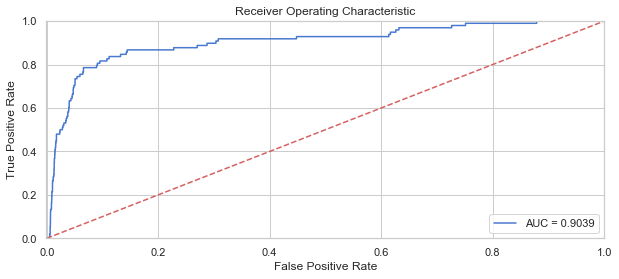

In [39]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### Prediction of Fraudlent Transaction

The next step is to use the model to identify outliers in new dataset. For this purpose we will use the test data (X_test). Thus the higher the reconstruction error for a data point the higher the chance that the data point is an outlier.

We need to set a threshold on the RE to separate normal data points and outliers. Setting the threshold is a very difficult task that needs domain knowledge and a good understanding of the data itself.

If the error is larger than a predefined threshold, we will mark it as a fraud (since our model should have a low error on normal transactions)

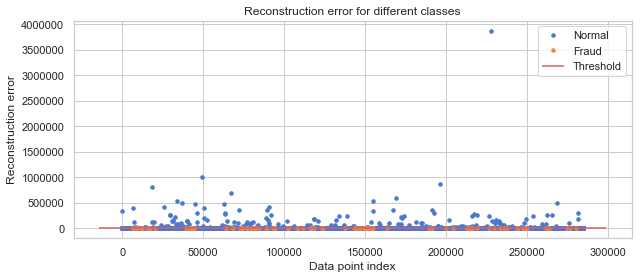

In [72]:
threshold = 12
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

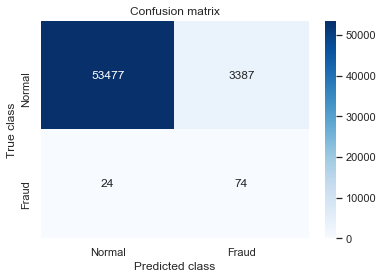

In [73]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, cmap="Blues",annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

* A Deep Autoencoder was created in Keras that can reconstruct what non fraudulent transactions looks like. 


* We gave a lot of positive-class examples (normal transactions) to the model and it learned (somewhat) how a positive class sample looks like.


* When presented with a fraud sample, it naturally had problems in reconstructing it, hence giving off a high reconstruction error.